### Nairobi Bus Travel  v 1.0

In [281]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from treeinterpreter import treeinterpreter as ti # To help use RFR as a feature engineering tool

### 1. First we put the data into the correct format

In [282]:
df_raw_train = pd.read_csv('train_revised.csv', low_memory=False)

In [283]:
df_raw_train.head()

,ride_id,seat_number,payment_method,payment_receipt,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity
0,1442,15A,Mpesa,UZUEHCBUSO,17-10-17,7:15,Migori,Nairobi,Bus,49
1,5437,14A,Mpesa,TIHLBUSGTE,19-11-17,7:12,Migori,Nairobi,Bus,49
2,5710,8B,Mpesa,EQX8Q5G19O,26-11-17,7:05,Keroka,Nairobi,Bus,49
3,5777,19A,Mpesa,SGP18CL0ME,27-11-17,7:10,Homa Bay,Nairobi,Bus,49
4,5778,11A,Mpesa,BM97HFRGL9,27-11-17,7:12,Migori,Nairobi,Bus,49


In [284]:
df_raw_train.describe()

,ride_id,max_capacity
count,51645.000000,51645.000000
mean,10188.645793,34.534321
std,2211.295708,18.451193
min,1442.000000,11.000000
25%,8287.000000,11.000000
50%,10353.000000,49.000000
75%,12029.000000,49.000000
max,20117.000000,49.000000


In [285]:
df_raw_train.drop(['seat_number', 'payment_method', 'payment_receipt', 'travel_to'], axis=1, inplace=True)

In [286]:
df_raw_train.head()

,ride_id,travel_date,travel_time,travel_from,car_type,max_capacity
0,1442,17-10-17,7:15,Migori,Bus,49
1,5437,19-11-17,7:12,Migori,Bus,49
2,5710,26-11-17,7:05,Keroka,Bus,49
3,5777,27-11-17,7:10,Homa Bay,Bus,49
4,5778,27-11-17,7:12,Migori,Bus,49


In [287]:
number_of_tickets = df_raw_train.groupby('ride_id').size(); number_of_tickets.describe()

count    6249.000000
mean        8.264522
std         8.632968
min         1.000000
25%         2.000000
50%         7.000000
75%        11.000000
max        50.000000
dtype: float64

In [288]:
number_of_tickets.sort_index(inplace=True)

In [289]:
# Just checking something
all(df_raw_train.duplicated() == df_raw_train.ride_id.duplicated())

True

In [290]:
# Since the above result is true, we can do this
df_raw_train.drop_duplicates(inplace=True)

In [291]:
df_raw_train.sort_values(by='ride_id',inplace=True)

In [292]:
df_raw_train['number_of_tickets'] = number_of_tickets.values

In [293]:
df_raw_train.describe()

,ride_id,max_capacity,number_of_tickets
count,6249.000000,6249.000000,6249.000000
mean,9963.644583,30.392223,8.264522
std,2296.304872,18.997471,8.632968
min,1442.000000,11.000000,1.000000
25%,7989.000000,11.000000,2.000000
50%,10024.000000,49.000000,7.000000
75%,11917.000000,49.000000,11.000000
max,20117.000000,49.000000,50.000000


In [294]:
df_raw_train.head()

,ride_id,travel_date,travel_time,travel_from,car_type,max_capacity,number_of_tickets
0,1442,17-10-17,7:15,Migori,Bus,49,1
1,5437,19-11-17,7:12,Migori,Bus,49,1
2,5710,26-11-17,7:05,Keroka,Bus,49,1
3,5777,27-11-17,7:10,Homa Bay,Bus,49,5
4,5778,27-11-17,7:12,Migori,Bus,49,31


In [295]:
# Let's just save it in case we need to load it somewhere
df_raw_train.to_csv('train_data_transformed.csv', index=False)

### 2. EDA and Feature Engineering

In [296]:
df_raw_train.corr()

,ride_id,max_capacity,number_of_tickets
ride_id,1.000000,0.257885,0.093817
max_capacity,0.257885,1.000000,0.208762
number_of_tickets,0.093817,0.208762,1.000000


###### Now we create further columns to help us see futher into the data

In [297]:
df_raw_train["travel_hour"] = df_raw_train["travel_time"].str.split(':').apply(lambda x: int(x[0]))

In [298]:
# Convert travel_date to a datetime variable
df_raw_train["travel_date"] = pd.to_datetime(df_raw_train["travel_date"],infer_datetime_format=True)
df_raw_train["travel_month"] = df_raw_train["travel_date"].dt.strftime('%Y-%m') #change the full date to day of week

In [299]:
df_raw_train.head()

,ride_id,travel_date,travel_time,travel_from,car_type,max_capacity,number_of_tickets,travel_hour,travel_month
0,1442,2017-10-17,7:15,Migori,Bus,49,1,7,2017-10
1,5437,2017-11-19,7:12,Migori,Bus,49,1,7,2017-11
2,5710,2017-11-26,7:05,Keroka,Bus,49,1,7,2017-11
3,5777,2017-11-27,7:10,Homa Bay,Bus,49,5,7,2017-11
4,5778,2017-11-27,7:12,Migori,Bus,49,31,7,2017-11


###### Let's see which hour people travel the most

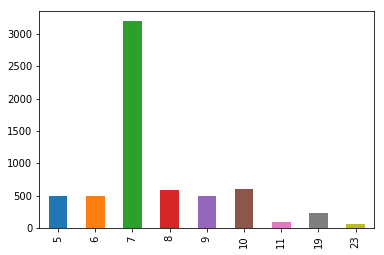

In [300]:
df_raw_train.travel_hour.value_counts().sort_index().plot.bar()

###### Seems a lot of people travel in the morning, that is definitly a good feature to include

###### Similarly, let's see which month people travel the most

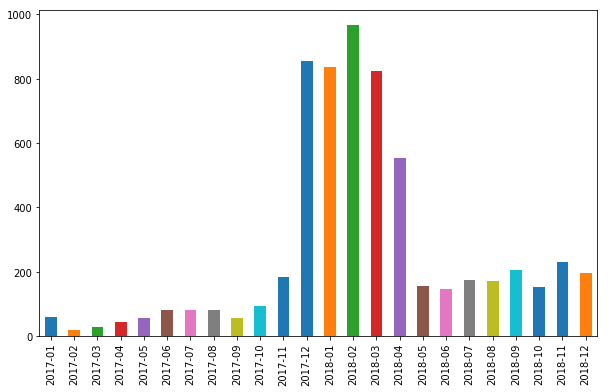

In [301]:
df_raw_train.travel_month.value_counts().sort_index().plot.bar(figsize=[10,6])

It is clear that travel periods are necessarily different for each month, it then makes up for a good feature candidate. However, the trend might not be stable for subsequent years to come. A better conclusion about the months can be reached with more years to analyze. But just for the fact that travels vary really well within each month is a justification on its effects on the data.  The problem is that it might introduce some over fitting that might reduce accuraccy of future predictions.

#### Next we find out which travel method is mostly patronized

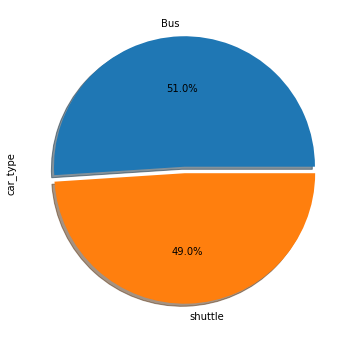

In [302]:
df_raw_train.car_type.value_counts().sort_index().plot.pie(figsize=[10,6], shadow=True, autopct='%1.1f%%', explode=(0.05,0))

The most used means of transport is the buses, but this could be due to the fact that there are a merely a lot of buses in use as compared to the shuttle. And that is most certainly the case as a little googling around shows that the buses used to be the main vehicle of transport in Kenya, and the shuttles are an attempt to replace the buses. 

###### The next question that comes to our mind is does the ride capacity affect the number of tickets? It is a natural question to ask since given that a bus takes more passengers compared to shuttle then it is likely to fetch more tickets. Or is it not?

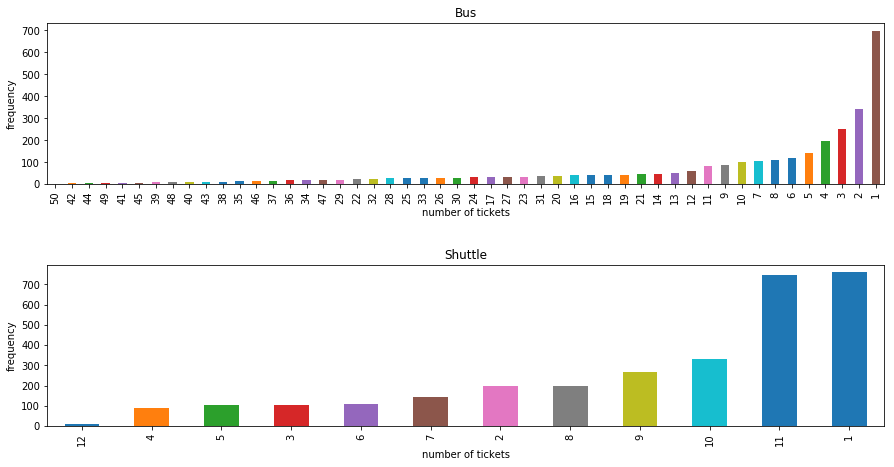

In [303]:
fig, axe = plt.subplots(2,1)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
df_raw_train.loc[df_raw_train.groupby('car_type').groups['Bus']].number_of_tickets.value_counts().sort_values().plot(kind='bar',title='Bus', ax=axe[0], figsize=(15,7))
df_raw_train.loc[df_raw_train.groupby('car_type').groups['shuttle']].number_of_tickets.value_counts().sort_values().plot(kind='bar',title='Shuttle', ax=axe[1], figsize=(15,7))
for axi in axe:
    axi.set_xlabel("number of tickets")
    axi.set_ylabel("frequency")

This says something but it's not very clear, let's add one more column to our data **fill_percent** which tells us the percentage of the ride's capacity that was filled before take off.

In [304]:
df_raw_train['fill_percent'] = (df_raw_train['number_of_tickets']/df_raw_train['max_capacity']).round(2)

In [305]:
df_raw_train.head()

,ride_id,travel_date,travel_time,travel_from,car_type,max_capacity,number_of_tickets,travel_hour,travel_month,fill_percent
0,1442,2017-10-17,7:15,Migori,Bus,49,1,7,2017-10,0.02
1,5437,2017-11-19,7:12,Migori,Bus,49,1,7,2017-11,0.02
2,5710,2017-11-26,7:05,Keroka,Bus,49,1,7,2017-11,0.02
3,5777,2017-11-27,7:10,Homa Bay,Bus,49,5,7,2017-11,0.10
4,5778,2017-11-27,7:12,Migori,Bus,49,31,7,2017-11,0.63


In [306]:
df_raw_train.groupby('car_type')['fill_percent'].describe()

,count,mean,std,min,25%,50%,75%,max
car_type,,,,,,,,
Bus,3189.0,0.203744,0.227452,0.02,0.04,0.10,0.29,1.02
shuttle,3060.0,0.584144,0.371146,0.09,0.18,0.73,0.91,1.09


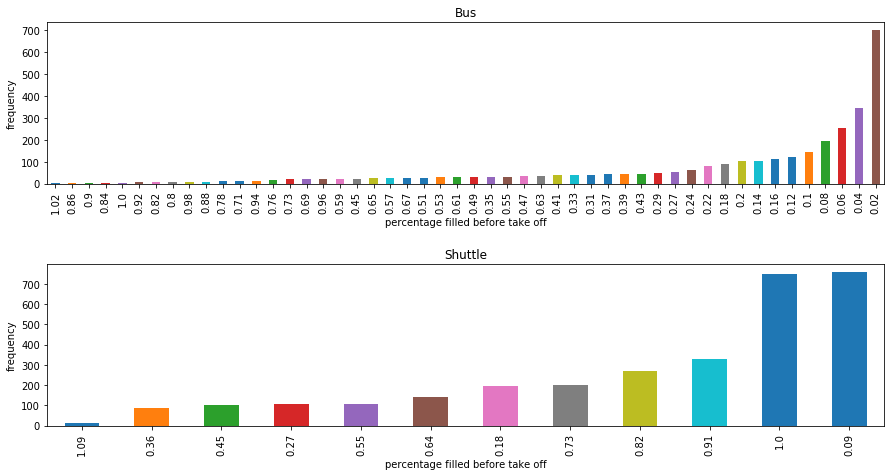

In [307]:
fig, axe = plt.subplots(2,1)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
df_raw_train.loc[df_raw_train.groupby('car_type').groups['Bus']].fill_percent.value_counts().sort_values().plot(kind='bar',title='Bus', ax=axe[0], figsize=(15,7))
df_raw_train.loc[df_raw_train.groupby('car_type').groups['shuttle']].fill_percent.value_counts().sort_values().plot(kind='bar',title='Shuttle', ax=axe[1], figsize=(15,7))
for axi in axe:
    axi.set_xlabel("percentage filled before take off")
    axi.set_ylabel("frequency")

In [308]:
# df_raw_train.groupby('car_type')['number_of_tickets'].value_counts()

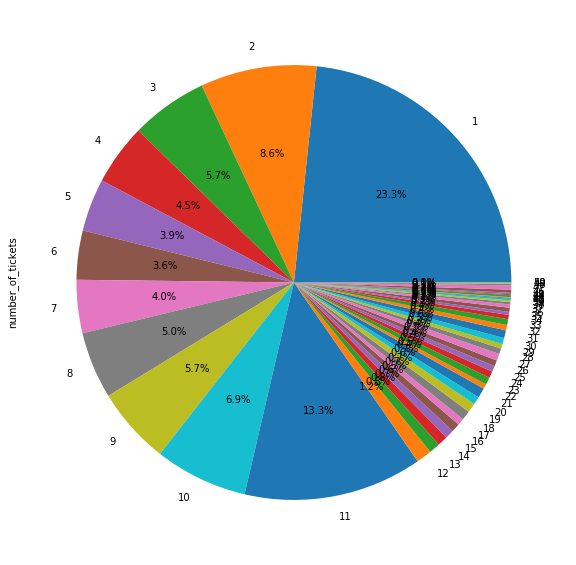

In [309]:
df_raw_train.number_of_tickets.value_counts().sort_index().plot.pie(figsize=[10,10], autopct='%1.1f%%')

We get the same sort of picture from the two different approaches. The interpretation is that shiuttles mostly get filled up or close to filled up before leaving, buses on the other hand do not seem to car about what percentage of it is filled. From the first picture however, one can see that this really makes no difference due to the fact that buses are larger than shuttles and hence looking at the percentages might be deceiving.

But one can see that the usual most prominent take off number amongst the two ranges from 1 - 11 as in the pie chart above

###### Next we find out how which cities have the most travelling individuals into Nairobi

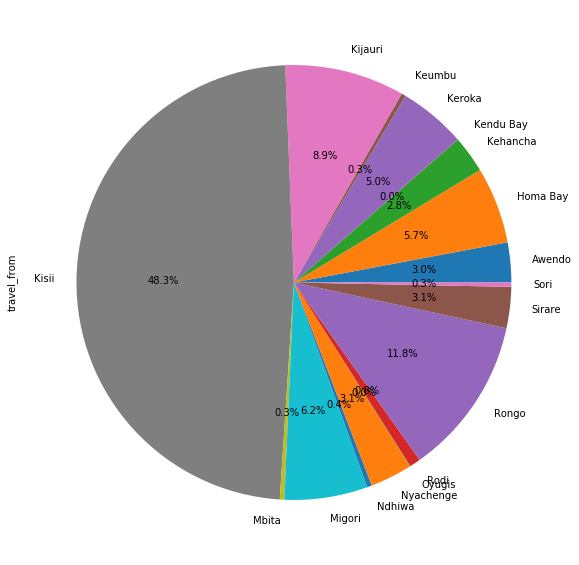

In [310]:
df_raw_train.travel_from.value_counts().sort_index().plot.pie(figsize=[10,10], autopct='%1.1f%%')

From the above image, one can clearly see the influence each city have on the data as we have more travellers coming from cities like **kisii** and very few from cities like **kendu bay** at almost *0%*.

Given this fact why not do all the above analysis for each city.

In [311]:

def plot_all(col, subplots = (5,4), fsize = (10,5), x='', y='', kind='bar', index=False):
    fig, axe = plt.subplots(5,4)
    plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.7)
    k,s = 0,0
    for group in df_raw_train.groupby('travel_from').groups.items():
#         print(group[1])
        if index:
            df_raw_train.loc[group[1]].loc[:,col].value_counts().sort_index().plot(kind=kind,title=group[0], ax=axe[k,s], figsize=fsize)
        else:
            df_raw_train.loc[group[1]].loc[:,col].value_counts().sort_values().plot(kind=kind,title=group[0], ax=axe[k,s], figsize=fsize)
        axe[k,s].set_xlabel(x)
        axe[k,s].set_ylabel(y)
        s += 1
        if s % 4 == 0:
            s = 0
            k += 1
        if k+1 % 5 == 0:
            print('k overflow ...')
            break # Not supposed to happen so don't even make it happen


###### Let's see which hour people travel the most for each town

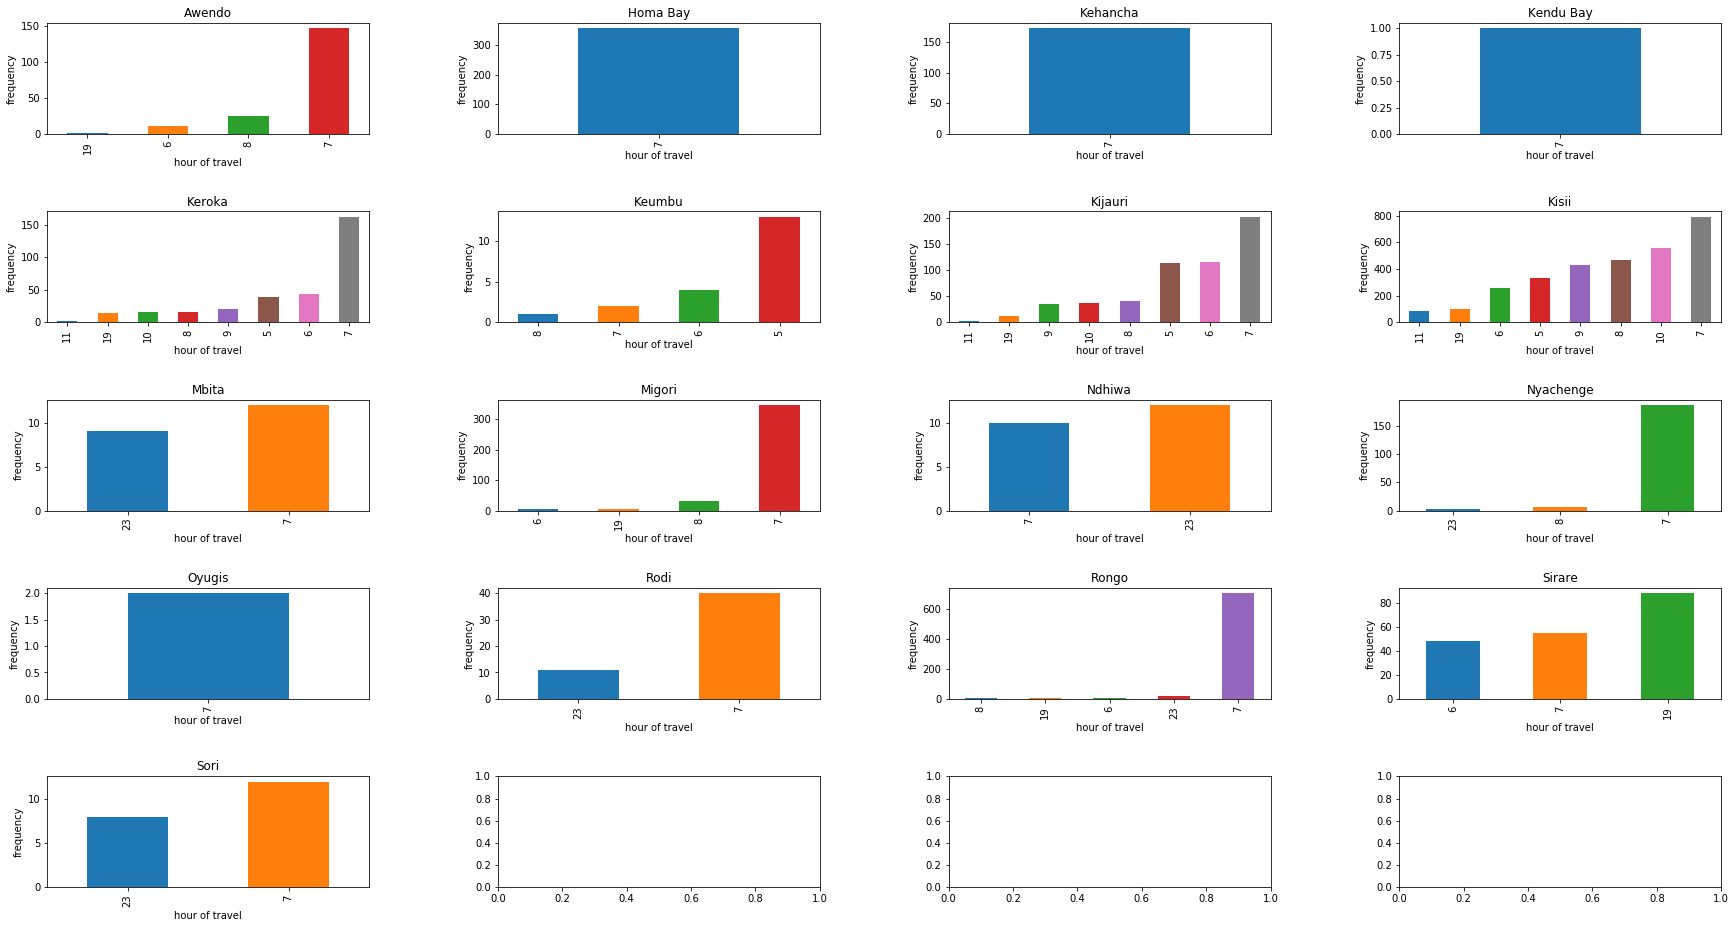

In [312]:
plot_all('travel_hour', fsize=(30,15), x='hour of travel', y='frequency')

There lies much variation for each city with respect to travelling hour. It can be seen that the general picture depicted is not the case for all, this might lead to some usefull modelling strategies.

###### Similarly, let's see which month people travel the most for each town

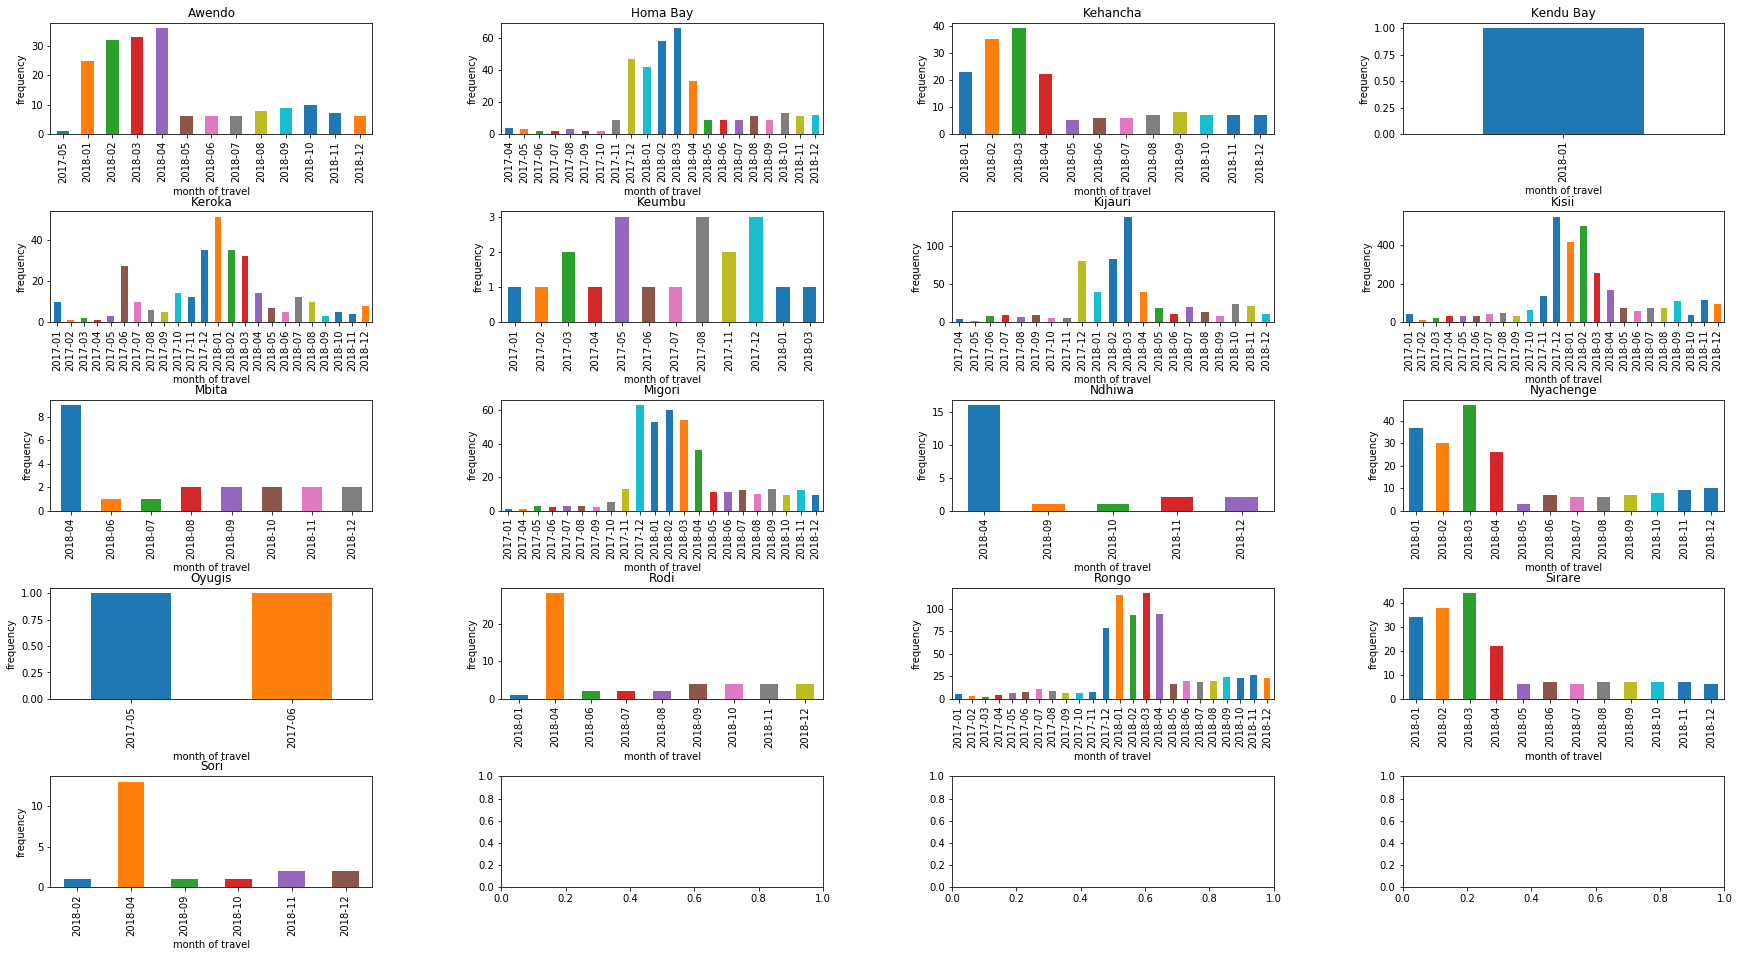

In [313]:
plot_all('travel_month', fsize=(30,15), x='month of travel', y='frequency',index=True)

Yet again we find that the picture as depicted by the whole is not the same for each city, although that is mostly the case, it is different and that we believe is important

#### Next we find out which travel method is mostly patronized for each town

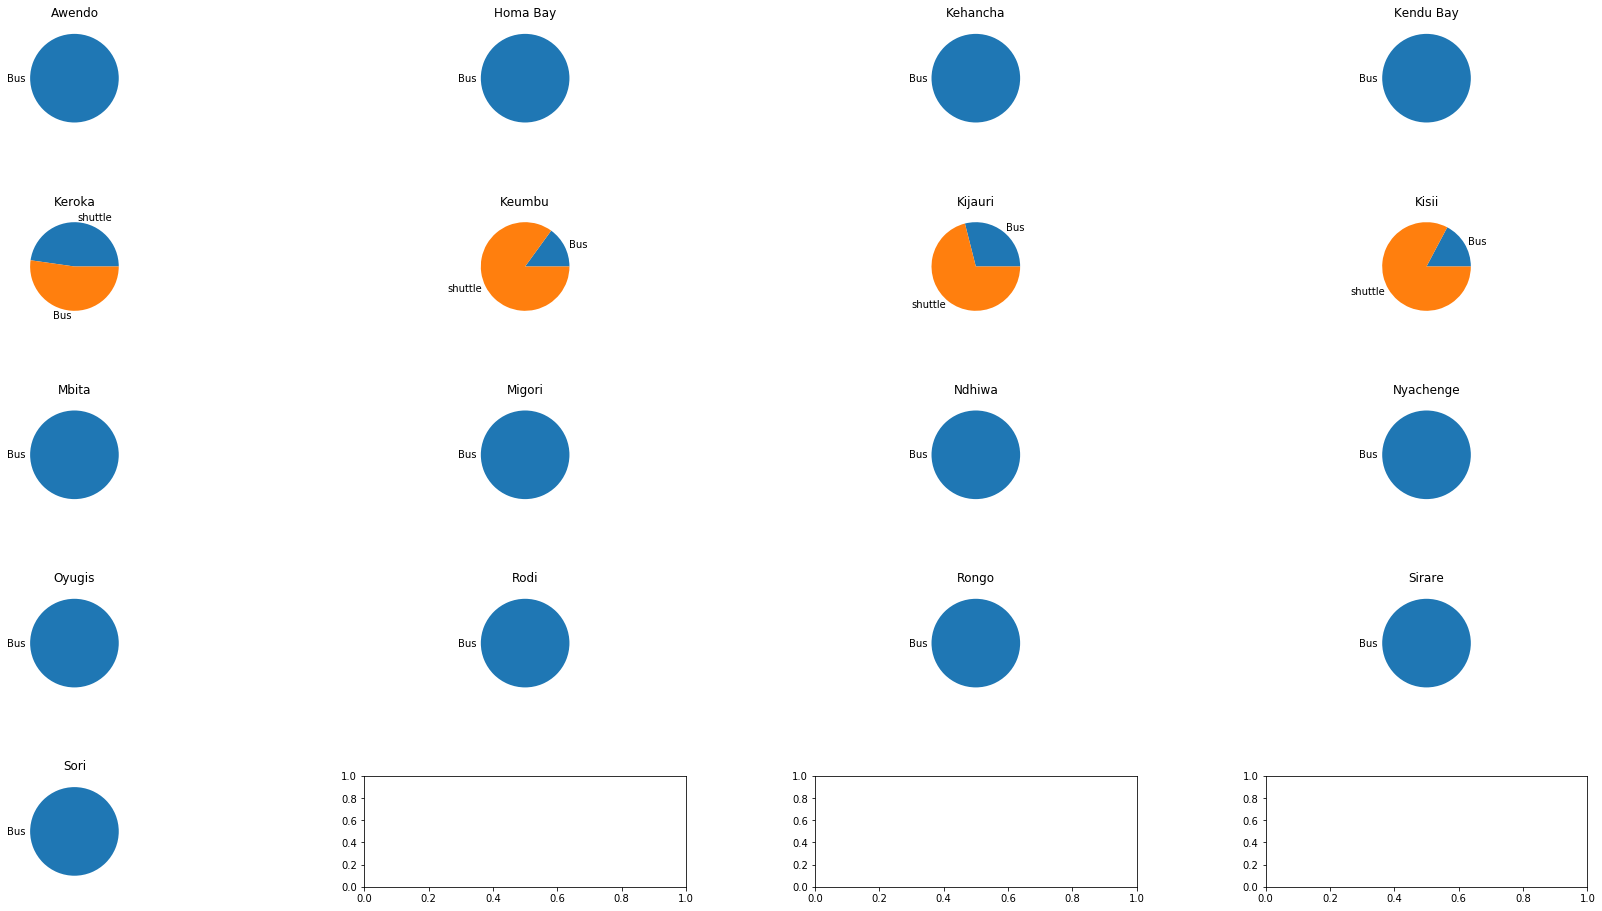

In [314]:
plot_all('car_type', fsize=(30,15), kind='pie')

This picture right here is the most shocking one, it turns out that only four towns use shuttles, i.e ('keroka', 'keumbu', 'kujauri', 'kisii') and yet shuttles makes up *49%* of all travels. This is clearly due to the fact that most of the travels are contributed from these towns. Further investigations as to why might not be found in the data.

#### This might not be important, but we still want to see how filled buses and shuttles get before leaving each city

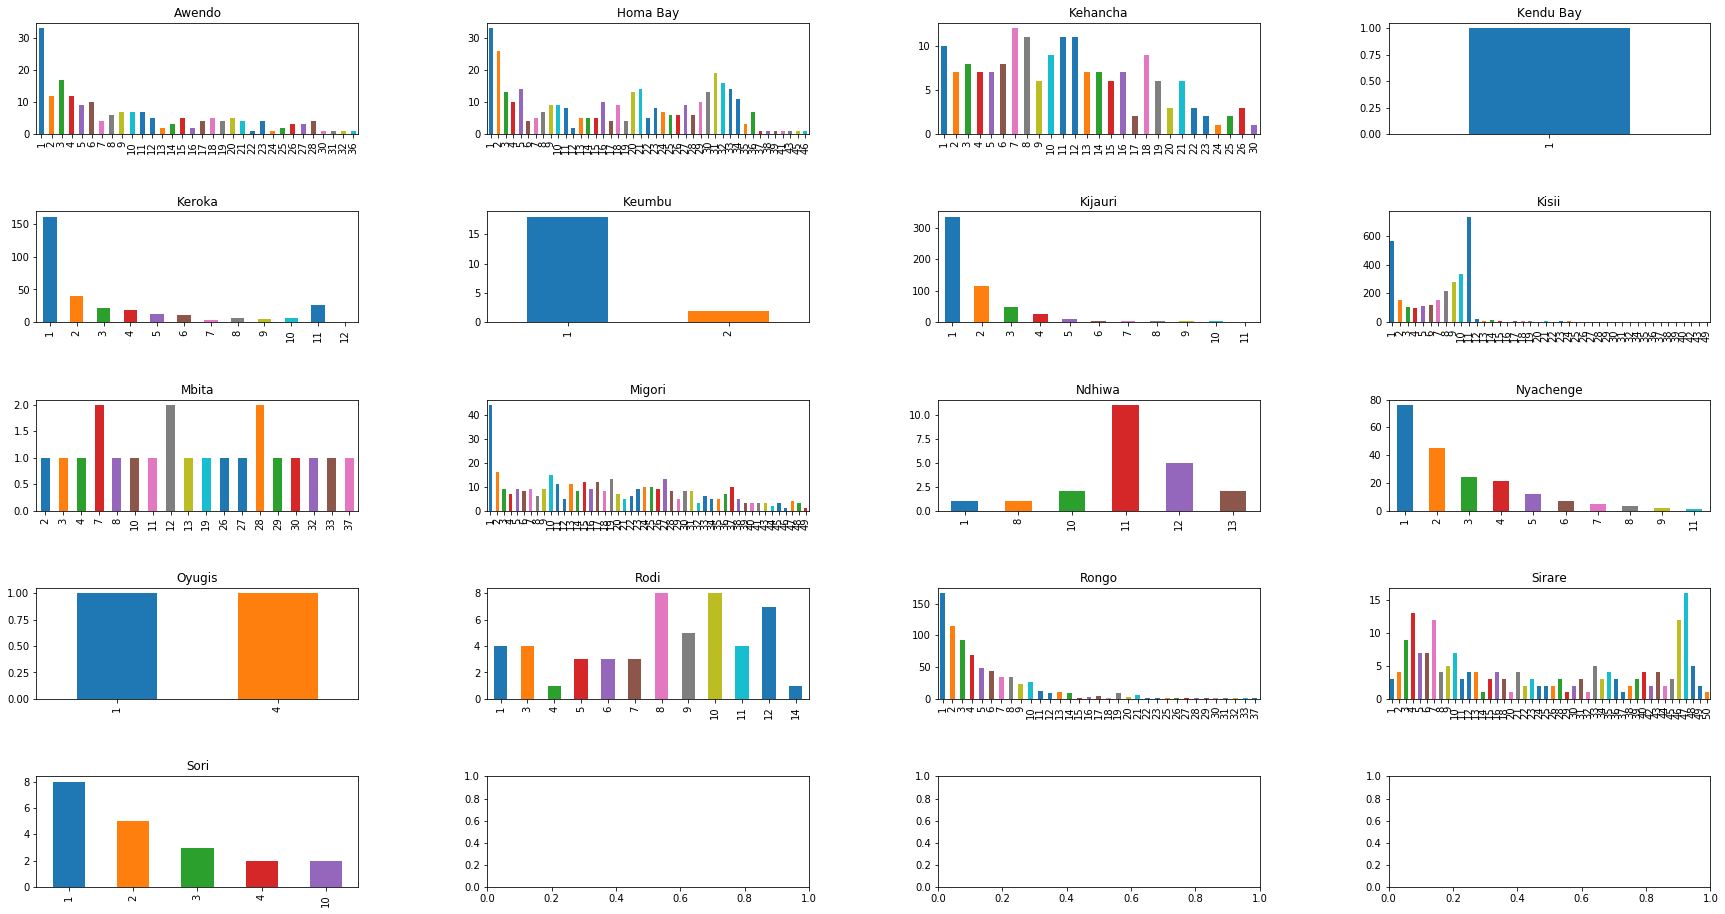

In [315]:
plot_all('number_of_tickets', fsize=(30,15), index=True)

Hmmm, this is interesting

#### Now we dive into random forest and even more feature engineering using random forest itself to tell us about the important factors, also we will test out a model for each of the cities looking at the kind of variation they introduce, it kind of feels natural to make a separate random forest model for each of them.
We consider the following feature set
1. travel_time
2. travel_from
3. car_type
4. travel_hour
5. travel_month *(just considering the month of travel)*

In [316]:
df_transformed = pd.read_csv('train_data_transformed.csv')
df_transformed.head()

,ride_id,travel_date,travel_time,travel_from,car_type,max_capacity,number_of_tickets
0,1442,17-10-17,7:15,Migori,Bus,49,1
1,5437,19-11-17,7:12,Migori,Bus,49,1
2,5710,26-11-17,7:05,Keroka,Bus,49,1
3,5777,27-11-17,7:10,Homa Bay,Bus,49,5
4,5778,27-11-17,7:12,Migori,Bus,49,31


In [317]:
df_transformed.drop(['ride_id'], axis=1, inplace=True) #ride_id is unnecessary in training set

df_transformed["travel_date"] = pd.to_datetime(df_transformed["travel_date"],infer_datetime_format=True)
df_transformed["travel_day"] = df_transformed["travel_date"].dt.dayofweek #change the full date to day of week
df_transformed["travel_month"] = df_transformed["travel_date"].dt.month-1#change the full date to day of week

df_transformed["car_type"] = pd.Categorical(df_transformed["car_type"])
car_type_categories = df_transformed.car_type.cat.categories
df_transformed["car_type"] = df_transformed.car_type.cat.codes
# df_transformed["car_type"] += 1

df_transformed["travel_from"] = pd.Categorical(df_transformed["travel_from"])
travel_from_categories = df_transformed.travel_from.cat.categories
df_transformed["travel_from"] = df_transformed.travel_from.cat.codes
# df_transformed["travel_from"] += 1

#express travel time in float
df_transformed["travel_time"] = df_transformed["travel_time"].str.split(':').apply(lambda x: float(x[0]) + round(float(x[1])/60,3))

In [318]:
df_transformed.drop(["travel_date","max_capacity"], axis=1, inplace=True)

In [319]:
df_transformed.head()

,travel_time,travel_from,car_type,number_of_tickets,travel_day,travel_month
0,7.250,9,0,1,1,9
1,7.200,9,0,1,6,10
2,7.083,4,0,1,6,10
3,7.167,1,0,5,0,10
4,7.200,9,0,31,0,10


In [320]:
df_transformed.describe() # check if nothing is missing

,travel_time,travel_from,car_type,number_of_tickets,travel_day,travel_month
count,6249.000000,6249.000000,6249.000000,6249.000000,6249.000000,6249.000000
mean,8.239828,7.481037,0.489678,8.264522,2.913906,4.761402
std,2.951847,3.688104,0.499933,8.632968,1.958013,4.076164
min,5.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,7.067000,6.000000,0.000000,2.000000,1.000000,1.000000
50%,7.167000,7.000000,0.000000,7.000000,3.000000,3.000000
75%,8.667000,9.000000,1.000000,11.000000,5.000000,9.000000
max,23.167000,16.000000,1.000000,50.000000,6.000000,11.000000


### The Random Forest Adventure and Parameter Tunning

In [321]:
X = df_transformed.drop(["number_of_tickets"], axis=1)
y = df_transformed.number_of_tickets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=99)
X_train.shape, y_train.shape, X_test.shape, y_test.shape,X.shape,y.shape

((4374, 5), (4374,), (1875, 5), (1875,), (6249, 5), (6249,))

In [322]:
rfr = RandomForestRegressor(n_estimators=350, oob_score = True, criterion="mae",
                              n_jobs=-1, max_features = 4, min_samples_leaf = 3,
                              random_state=77)

rfr.fit(X_test,y_test)

preds_train_set = rfr.predict(X_train)
print(mean_absolute_error(preds_train_set.round(),y_train))

3.6707818930041154


###### We train the model with all the data for the real test predictions

In [323]:

rfr = RandomForestRegressor(n_estimators=350, oob_score = True, criterion="mae",
                              n_jobs=-1, max_features = 4, min_samples_leaf = 3,
                           random_state=77)

rfr.fit(X,y)

preds_train_set = rfr.predict(X)
print(mean_absolute_error(preds_train_set.round(),y))

2.7100336053768603


#### <span style='color:red'>Please Ignore, We Are Just Trying Out Other Stuff. *Seriously it actually takes longer to run*</span>

In [324]:
gbr = GradientBoostingRegressor(n_estimators=350, criterion="mae", max_features = 4,min_samples_leaf = 3,
                              random_state=77).fit(X_train, y_train)
print(mean_absolute_error(y_test, gbr.predict(X_test).round()))

3.6693333333333333


In [325]:
abr = AdaBoostRegressor(DecisionTreeRegressor(min_samples_leaf = 3,criterion="mae", max_features = 4 ),n_estimators=350,random_state=77).fit(X_train, y_train)
print(mean_absolute_error(y_test, abr.predict(X_test).round()))

4.4216


#### Predictions for test set

In [326]:
df_test_q = pd.read_csv('test_questions.csv', low_memory=False)
df_test_q.head()

,ride_id,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity
0,247,2018-05-07,07:06,Kisii,Nairobi,Bus,49
1,256,2018-05-06,11:08,Kisii,Nairobi,shuttle,11
2,275,2018-05-04,05:00,Kisii,Nairobi,shuttle,11
3,285,2018-05-04,09:10,Kisii,Nairobi,shuttle,11
4,286,2018-05-04,09:20,Kisii,Nairobi,shuttle,11


In [327]:
df_test_q.describe()

,ride_id,max_capacity
count,1111.000000,1111.000000
mean,9166.707471,31.487849
std,5685.112584,18.950186
min,247.000000,11.000000
25%,3809.500000,11.000000
50%,13844.000000,49.000000
75%,14602.500000,49.000000
max,15344.000000,49.000000


In [328]:
df_test_q["travel_date"] = pd.to_datetime(df_test_q["travel_date"],infer_datetime_format=True)
df_test_q["travel_day"] = df_test_q["travel_date"].dt.dayofweek # change the full date to day of week
df_test_q["travel_month"] = df_test_q["travel_date"].dt.month-1 # change the full date to day of week

df_test_q["car_type"] = pd.Categorical(df_test_q["car_type"])
car_type_categories = df_test_q.car_type.cat.categories
df_test_q["car_type"] = df_test_q.car_type.cat.codes
# df_test_q["car_type"] += 1

df_test_q["travel_from"] = pd.Categorical(df_test_q["travel_from"])
travel_from_categories = df_test_q.travel_from.cat.categories
df_test_q["travel_from"] = df_test_q.travel_from.cat.codes
# df_transformed["travel_from"] += 1

#express travel time in float
df_test_q["travel_time"] = df_test_q["travel_time"].str.split(':').apply(lambda x: float(x[0]) + round(float(x[1])/60,3))

In [329]:
df_test_q.drop(['travel_date','travel_to','max_capacity'],axis=1,inplace=True)

In [330]:
df_test_q.head() # ready to be used 

,ride_id,travel_time,travel_from,car_type,travel_day,travel_month
0,247,7.100,5,0,0,4
1,256,11.133,5,1,6,4
2,275,5.000,5,1,4,4
3,285,9.167,5,1,4,4
4,286,9.333,5,1,4,4


In [331]:
df_test_q.describe()

,ride_id,travel_time,travel_from,car_type,travel_day,travel_month
count,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000
mean,9166.707471,9.571528,6.006301,0.460846,2.737174,3.326733
std,5685.112584,4.618765,3.335984,0.498689,1.954725,0.469230
min,247.000000,5.000000,0.000000,0.000000,0.000000,3.000000
25%,3809.500000,7.083000,5.000000,0.000000,1.000000,3.000000
50%,13844.000000,7.217000,5.000000,0.000000,3.000000,3.000000
75%,14602.500000,10.667000,7.000000,1.000000,4.000000,4.000000
max,15344.000000,23.200000,14.000000,1.000000,6.000000,4.000000


In [334]:
T = df_test_q.drop(['ride_id'], axis=1)
T_predictions = rfr.predict(T)
T.shape, T_predictions.shape

((1111, 5), (1111,))

In [335]:
### Now we store our predictions in a csv file as required

In [336]:
d = {'ride_id': df_test_q["ride_id"], 'number_of_ticket': T_predictions.round()}
df_predictions = pd.DataFrame(data=d)
df_predictions = df_predictions[['ride_id','number_of_ticket']]

In [337]:
df_predictions.head()

,ride_id,number_of_ticket
0,247,2.0
1,256,1.0
2,275,1.0
3,285,1.0
4,286,1.0


In [338]:
df_predictions.to_csv('predicted.csv')